# **Customer Segmentation project**
## **TO GRANT OR NOT TO GRANT**


## Context

The project aims to create a multiclass classification model to predict the Claim Injury Type based on claims data from the New York Workers' Compensation Board (WCB) between 2020 and 2022. This model will help automate the decision-making process regarding compensation, which is currently done manually and is time-consuming.

## Expected outcomes

The project expects to create a multiclass classification model that accurately predicts the Claim Injury Type based on claims data provided by the New York Workers' Compensation Board (WCB). By automating the decision-making process for these claims, the model will reduce the time and effort spent on manual review. The expected outcomes include:

*   **Accurate prediction** of the type of injury (Claim Injury Type) using a benchmark model.
*   **Model optimization**, including fine-tuning and hyper-parameter adjustments to improve performance.
*   **Additional insights**, such as feature importance analysis and exploring alternative variables (e.g., WCB Decision or Agreement Reached) to further enhance the model.






## Column Name Descriptions


*   **Accident Date**: Injury date of the claim.
*   **Age at Injury**: Age of injured worker when the injury occurred.
*   **Alternative Dispute Resolution**:Adjudication processes external to the Board.
*   **Assembly Date**: The date the claim was first assembled.
*   **Attorney/Representative**: Is the claim being represented by an Attorney?
*   **Average Weekly Wage:** The wage used to calculate workers’ compensation,disability, or an Paid Leave wage replacement benefits.
*   **Birth Year:** The reported year of birth of the injured worker.
*   **C-2 Date:** Date of receipt of the Employer's Report of Work-Related, Injury/Illness or equivalent (formerly Form C-2).
*   **C-3 Date:** Date Form C-3 (Employee Claim Form) was received.
*   **Carrier Name:** Name of primary insurance provider responsible for
providing workers’ compensation coverage to the injured
worker’s employer.
*   **Carrier Type:** Type of primary insurance provider responsible for providing
workers’ compensation coverage.
*   **Claim Identifier:** Unique identifier for each claim, assigned by WCB.
*   **County of Injury:** Name of the New York County where the injury occurred.
*   **COVID-19 Indicator**: Indication that the claim may be associated with COVID-19.
*   **District Name**: Name of the WCB district office that oversees claims for that region or area of the state.
*   **First Hearing Date:** Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.
Gender: The reported gender of the injured worker.
*   **IME-4 Count:** Number of IME-4 forms received per claim. The IME-4 form is the "Independent Examiner's Report of Independent Medical Examination" form.
*   **Industry Code:** NAICS code and descriptions are available at: https://www.naics.com/search-naics-codes-by-industry/.
*   **Industry Code Description:** 2-digit NAICS industry code description used to classify businesses according to their economic activity.
*   **Medical Fee Region:** Approximate region where the injured worker would receive medical service.
*   **OIICS Nature of Injury Description:** The OIICS nature of injury codes & descriptions are available at https://www.bls.gov/iif/oiics_manual_2007.pdf.
*   **WCIO Cause of Injury Code:** The WCIO cause of injury codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.
*   **WCIO Cause of Injury Description:** See description of field above.
*   **WCIO Nature of Injury Code: **The WCIO nature of injury codes are available at https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.
*   **WCIO Nature of Injury Description: **See description of field above.
*   **WCIO Part Of Body Code**: The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.
*   **WCIO Part Of Body Description:** See description of field above.
*   **Zip Code:** The reported ZIP code of the injured worker’s home address.
*  **Agreement Reached: Binary variable:** Yes if there is an agreement without the involvement of the WCB -> **unknown** at the start of a claim.
*   **WCB Decision:** **Multiclass variable:** Decision of the WCB relative to the claim: "Accident" means that claim refers to workplace accident, "Occupational Disease" means illness from the workplace. -> **requires WCB deliberation** so it is unknown at the start of a claim.
*   **Claim Injury Type:** **Main target variable**: Deliberation of the WCB relative to benefits awarded to the claim. **Numbering indicates severity.**







































# **Libraries and Functions**

### **Import necessary libraries**



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Visualização de dados ausentes
import missingno as msno

# Métodos de particionamento de dados
from sklearn.model_selection import train_test_split, GridSearchCV

# Métodos de filtragem: Spearman e Qui-Quadrado
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Métodos de seleção de características
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# Escalador
from sklearn.preprocessing import MinMaxScaler

# Métricas de desempenho
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    make_scorer
)

# Biblioteca matemática
from math import ceil

# Configurações do pandas para exibir mais colunas e linhas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

# Suprimir avisos
import warnings
warnings.filterwarnings("ignore")


## **Functions**

### Read CSV from Google Colab or Local Machine

In [8]:
import pandas as pd
import os

def load_file(file_path_or_sheet_id, sheet_name=None, df_name='data', colab_wd=None):
    """
    Loads data from a Google Sheet in Colab or from a local CSV file otherwise.

    Args:
        file_path_or_sheet_id (str): The path to the local CSV file or the ID of the Google Sheet.
        sheet_name (str, optional): The name of the sheet to load (only for Google Sheets). Defaults to None.
        df_name (str, optional): The name of the DataFrame variable to return. Defaults to 'data'.
        colab_wd (str, optional): The working directory path in Google Colab. Defaults to None.

    Returns:
        pd.DataFrame: The loaded DataFrame.
    """
    # Check if running in Google Colab
    try:
        from google.colab import auth, drive
        auth.authenticate_user()
        import gspread
        from oauth2client.client import GoogleCredentials
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
        print("Detected environment: Google Colab")
        # Always load from Google Sheet if in Colab
        gc = gspread.authorize(GoogleCredentials.get_application_default())
        sheet = gc.open_by_key(file_path_or_sheet_id).worksheet(sheet_name)
        data = sheet.get_all_values()
        globals()[df_name] = pd.DataFrame(data[1:], columns=data[0])
        print(f"Data successfully loaded from Google Sheet: {sheet_name}")
    else:
        print("Detected environment: Local")
        wd = os.getcwd()
        full_path = os.path.join(wd, file_path_or_sheet_id)
        globals()[df_name] = pd.read_csv(full_path)
        print(f"File successfully loaded from: {full_path}")

    return globals()[df_name]

In [9]:
# Code was developed by team so that we can run the code both in Google Colab
# and on the local machine without much hassle

def load_file(filename, df_name, colab_wd=None):
    """
    Loads and extracts a CSV file depending on the environment: Google Colab or local machine.
    The DataFrame is stored with the name provided by the df_name argument.

    Arguments:
    filename -- The name of the file to load.
    df_name -- The name of the DataFrame variable to return (converted to string).
    colab_wd -- The working directory path in Google Colab (required in Colab).

    Raises:
    ValueError: If colab_wd is not provided when running in Google Colab.
    FileNotFoundError: If the specified file is not found.
    pd.errors.ParserError: If there is an error parsing the CSV file.
    Exception: For any other unexpected errors during file loading.
    """
    # Check if running in Google Colab (or Jupyter Notebook in Colab)
    try:
        from google.colab import drive
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
        print("Detected environment: Google Colab")
        if colab_wd is None:
            raise ValueError("colab_wd parameter is required when running in Google Colab.")
        # If not already mounted, mount Google Drive
        if not os.path.exists('/content/drive'):
            drive.mount('/content/drive')
        # Set the working directory (use provided)
        wd = colab_wd
        # Check if working directory exists, create if not
        if not os.path.exists(wd):
            os.makedirs(wd)
        os.chdir(wd)
        full_path = os.path.join(wd, filename)

    else:
        print("Detected environment: Local")
        # Set the local directory (modify based on your local setup)
        wd = os.getcwd()
        full_path = os.path.join(wd, filename)

    # Convert df_name to string, if not already a string
    df_name_str = str(df_name)

    # Load the file with error handling
    try:
        data = pd.read_csv(full_path)
        print(f"File successfully loaded from: {full_path}")
        globals()[df_name_str] = data
        return data  # Return the DataFrame
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found at: {full_path}")
    except pd.errors.ParserError:
        raise pd.errors.ParserError(f"Error parsing CSV file at: {full_path}")
    except Exception as e:
        raise Exception(f"An unexpected error occurred: {e}")

### Plot a boxplot and a histogram along the same scale

In [10]:
# Original code was used at an online learning session by Utexas Austin
# Changed code with assistance from Gemini and ChatGPT to include showfliers, key statistics and location options

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None, showfliers=True, text_loc='upper right'):
    """
    Boxplot and histogram combined.

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    showfliers: whether to show outliers in the boxplot (default True)
    text_loc: location of the descriptive statistics text ('upper left', 'upper right')
    """
    # Validate text_loc input
    valid_text_locs = ['upper left', 'upper right']
    if text_loc not in valid_text_locs:
        raise ValueError(f"Invalid value for text_loc: '{text_loc}'. Expected one of {valid_text_locs}.")

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )

    # Calculate quantiles to determine outliers
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Filter data for the histogram based on showfliers
    if not showfliers:
        data_filtered = data[(data[feature] >= Q1 - 1.5 * IQR) & (data[feature] <= Q3 + 1.5 * IQR)]
    else:
        data_filtered = data

    # Plot boxplot and histogram
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="violet", showfliers=showfliers)

    # Check if bins is not None before passing it to sns.histplot
    if bins:
        sns.histplot(data=data_filtered, x=feature, kde=kde, ax=ax_hist2, bins=bins)
    else:
        sns.histplot(data=data_filtered, x=feature, kde=kde, ax=ax_hist2)

    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")  # Mean line
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")  # Median line

    # Calculate key statistics
    mean = data[feature].mean()
    median = data[feature].median()
    std = data[feature].std()
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    minimum = data[feature].min()
    maximum = data[feature].max()
    count = data[feature].count()
    n_missing = data[feature].isna().sum()

    # Key statistics text
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mean,),
        r'$\mathrm{median}=%.2f$' % (median,),
        r'$\sigma=%.2f$' % (std,),
        r'$Q1=%.2f$' % (q1,),
        r'$Q3=%.2f$' % (q3,),
        r'$min=%.2f$' % (minimum,),
        r'$max=%.2f$' % (maximum,),
        r'$count=%.0f$' % (count,),
        r'$n\_missing=%.0f$' % (n_missing,)))

    # Adjust position based on text_loc ('upper right' or 'upper left')
    if text_loc == 'upper right':
        ax_hist2.text(0.95, 0.95, textstr, transform=ax_hist2.transAxes, fontsize=12,
                      verticalalignment='top', horizontalalignment='right',
                      bbox=dict(facecolor='white', alpha=0.8))
        ax_box2.text(0.95, 0.95, f'Show Outliers: {showfliers}', transform=ax_box2.transAxes, fontsize=12,
                     verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    elif text_loc == 'upper left':
        ax_hist2.text(0.05, 0.95, textstr, transform=ax_hist2.transAxes, fontsize=12,
                      verticalalignment='top', horizontalalignment='left',
                      bbox=dict(facecolor='white', alpha=0.8))
        ax_box2.text(0.05, 0.95, f'Show Outliers: {showfliers}', transform=ax_box2.transAxes, fontsize=12,
                     verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

### *Barplot with percentage at the top*

In [11]:
# Original code was presented in an online training by the UTexas
# Used Gemini to help with changing the code so that operations are not carried out in place on the original dataset

import seaborn as sns
import matplotlib.pyplot as plt

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top, including NA values for both categorical and non-categorical features.
    This version does not modify the original dataframe.

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    # Make a copy of the dataframe to avoid modifying the original data
    data_copy = data.copy()

    # Handle categorical columns by adding 'NA' as a category before filling NaNs
    if data_copy[feature].dtype.name == 'category':
        data_copy[feature] = data_copy[feature].cat.add_categories('NA').fillna('NA')
    else:
        # Replace NaN values with 'NA' for non-categorical columns
        data_copy[feature] = data_copy[feature].fillna('NA')

    total = len(data_copy[feature])  # total length of the column including NAs
    count = data_copy[feature].nunique()  # number of unique values including 'NA'

    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)

    # Create the countplot, assigning 'x' to 'hue' and setting 'legend=False'
    ax = sns.countplot(
        data=data_copy,
        x=feature,
        hue=feature,  # Assign 'x' to 'hue'
        palette="Paired",
        order=data_copy[feature].value_counts().index[:n],  # Include NAs in the count
        legend=False  # Set legend to False
    )

    # Annotating the bars with counts or percentages
    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage or count

    plt.show()  # show the plot

### Compute CDF of numeric variables

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_cdf(df, column_name, line_value=None):
    """
    Generates a CDF plot for a single column of a DataFrame.
    Includes the variable name in the title, reduces whitespace,
    and adds horizontal and vertical lines at a specified value with annotations.
    Removes the legend from the chart.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
        line_value (float, optional): The value at which to draw the lines. Defaults to None.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the specified column
    sns.ecdfplot(ax=ax, x=df[column_name])
    ax.set_title(f"CDF of {column_name}")

    # Add lines and annotations if line_value is provided
    if line_value is not None:
        proportion = np.sum(df[column_name] <= line_value) / len(df[column_name])

        # Horizontal line with annotation
        ax.axhline(y=proportion, color='red', linestyle='--', label=f'{line_value} (Proportion: {proportion:.2f})')
        ax.text(df[column_name].min(), proportion + 0.02, f'{proportion:.2f}', color='red')

        # Vertical line with annotation
        ax.axvline(x=line_value, color='red', linestyle='--', label=f'{line_value} (x-value)')
        ax.text(line_value + 0.1, 0.02, f'{line_value}', color='red')

        # Remove the legend
        ax.legend().remove()  # This line removes the legend

    fig.tight_layout()
    plt.show()

### Import TO GRANT OR NOT TO GRANT dataset




In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd

# Caminhos dos arquivos CSV (depois de fazer upload no Colab)
file1 = '/content/drive/MyDrive/projeto ML/extracted_files/train_data.csv'
file2 = '/content/drive/MyDrive/projeto ML/extracted_files/test_data.csv'
file3 = '/content/drive/MyDrive/projeto ML/extracted_files/sample_submission.csv'

# Carregar os arquivos CSV em dataframes
df_train_data = pd.read_csv(file1)
df_test_data = pd.read_csv(file2)
df_sample_submission = pd.read_csv(file3)

# Exibir as primeiras linhas para verificar os dados
df_train_data



,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327160035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593467,2022-12-13,72.0,N,2022-12-31,N,0.00,1950.0,2022-12-31,NaN,TECHNOLOGY INSURANCE CO. INC.,1A. PRIVATE,6165075,2. NON-COMP,SULLIVAN,N,BINGHAMTON,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,I,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),90.0,MULTIPLE PHYSICAL INJURIES ONLY,-9.0,MULTIPLE,12779,0.0,Not Work Related,3.0
593468,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249875936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593469,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120584215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dataframe structure and datatypes

In [15]:
df_train_data.head(20)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
5,2019-12-26,67.0,N,2020-01-01,N,0.00,1952.0,2019-12-31,NaN,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,5393863,3. MED ONLY,SUFFOLK,N,HAUPPAUGE,NaN,M,NaN,44.0,RETAIL TRADE,IV,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,38.0,SHOULDER(S),11772,0.0,Not Work Related,5.0
6,2019-12-28,48.0,N,2020-01-01,N,0.00,1971.0,2019-12-31,NaN,LM INSURANCE CORP,1A. PRIVATE,5393848,2. NON-COMP,ONONDAGA,N,SYRACUSE,NaN,M,NaN,72.0,ACCOMMODATION AND FOOD SERVICES,I,NaN,19.0,"CUT, PUNCTURE, SCRAPE, NOC",40.0,LACERATION,36.0,FINGER(S),13029,0.0,Not Work Related,1.0
7,2019-12-30,33.0,N,2020-01-01,N,0.00,1986.0,2019-12-31,2020-03-04,STATE INSURANCE FUND,2A. SIF,5394182,2. NON-COMP,RICHMOND,N,NYC,NaN,F,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,IV,NaN,99.0,"OTHER - MISCELLANEOUS, NOC",71.0,"ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC",38.0,SHOULDER(S),10305,0.0,Not Work Related,6.0
8,2019-12-23,55.0,N,2020-01-01,N,0.00,1964.0,2020-01-01,NaN,"ROCHESTER, UNIVERSITY OF",4A. SELF PRIVATE,5393881,2. NON-COMP,MONROE,N,ROCHESTER,NaN,F,NaN,61.0,EDUCATIONAL SERVICES,II,NaN,99.0,"OTHER - MISCELLANEOUS, NOC",59.0,"ALL OTHER SPECIFIC INJURIES, NOC",60.0,LUNGS,14620,0.0,Not Work Related,6.0
9,2019-12-29,20.0,N,2020-01-01,N,225.00,NaN,2019-12-31,NaN,LM INSURANCE CORP,1A. PRIVATE,5394084,3. MED ONLY,KINGS,N,NYC,NaN,F,NaN,44.0,RETAIL TRADE,IV,NaN,81.0,"STRUCK OR INJURED, NOC",59.0,"ALL OTHER SPECIFIC INJURIES, NOC",14.0,EYE(S),11231,0.0,Not Work Related,6.0


In [16]:
df_test_data.head(10)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
0,2022-12-24,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,6165911,BRONX,N,NYC,NaN,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1
1,2022-11-20,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,1A. PRIVATE,6166141,QUEENS,N,NYC,NaN,F,NaN,45.0,RETAIL TRADE,IV,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1
2,2022-12-26,59,N,2023-01-02,N,0.00,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,1A. PRIVATE,6165907,WESTCHESTER,N,NYC,NaN,F,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,III,NaN,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0
3,2022-12-28,55,N,2023-01-02,N,0.00,0.0,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,6166047,QUEENS,N,NYC,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,6
4,2022-12-20,25,N,2023-01-02,N,0.00,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,6166102,KINGS,N,NYC,NaN,M,NaN,55.0,MANAGEMENT OF COMPANIES AND ENTERPRISES,IV,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,5
5,2022-12-28,36,N,2023-01-02,N,0.00,1986.0,2023-01-02,NaN,NYC TRANSIT AUTHORITY,3A. SELF PUBLIC,6165787,ORANGE,N,ALBANY,NaN,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,III,NaN,90.0,OTHER THAN PHYSICAL CAUSE OF INJURY,77.0,MENTAL STRESS,66.0,NO PHYSICAL INJURY,10941,4
6,2022-12-22,19,N,2023-01-02,N,688.20,2003.0,2022-12-30,NaN,"WAL-MART ASSOCIATES, INC.",4A. SELF PRIVATE,6166019,NIAGARA,N,BUFFALO,NaN,F,NaN,45.0,RETAIL TRADE,I,NaN,56.0,LIFTING,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14131,6
7,2022-12-13,43,N,2023-01-02,N,0.00,0.0,2023-01-02,NaN,ERIE INSURANCE CO OF NY,1A. PRIVATE,6166080,HERKIMER,N,SYRACUSE,NaN,M,NaN,72.0,ACCOMMODATION AND FOOD SERVICES,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,49.0,SPRAIN OR TEAR,53.0,KNEE,13357,4
8,2022-12-28,40,N,2023-01-02,N,0.00,1982.0,2022-12-31,NaN,STARR INDEMNITY & LIABILITY CO,1A. PRIVATE,6165976,QUEENS,N,NYC,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,IV,NaN,87.0,FOREIGN MATTER (BODY) IN EYE(S),25.0,FOREIGN BODY,14.0,EYE(S),11735,3
9,2022-11-01,48,N,2023-01-02,Y,1180.74,1974.0,2023-01-02,2023-01-09,STATE INSURANCE FUND,2A. SIF,6165953,CHAUTAUQUA,N,BUFFALO,2023-07-10,M,2.0,48.0,TRANSPORTATION AND WAREHOUSING,I,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14720,0


In [17]:
df_train_data.shape

(593471, 33)

In [18]:
df_test_data.shape

(387975, 30)

In [19]:
columns_name = df_train_data.columns
columns_name

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')

In [20]:
df_test_data.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code', 'Industry Code Description', 'Medical Fee Region',
       'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents'],
      dtype='object')

In [21]:
# Checking the dataframe structure and datatypes
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [22]:
# Checking the dataframe structure and datatypes
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387975 entries, 0 to 387974
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       385531 non-null  object 
 1   Age at Injury                       387975 non-null  int64  
 2   Alternative Dispute Resolution      387975 non-null  object 
 3   Assembly Date                       387975 non-null  object 
 4   Attorney/Representative             387975 non-null  object 
 5   Average Weekly Wage                 368771 non-null  float64
 6   Birth Year                          368505 non-null  float64
 7   C-2 Date                            378841 non-null  object 
 8   C-3 Date                            85216 non-null   object 
 9   Carrier Name                        387975 non-null  object 
 10  Carrier Type                        387975 non-null  object 
 11  Claim Identifier          

In [23]:
df_train_data.describe(include ='all')

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
count,570337,574026.000000,574026,593471,574026,5.453750e+05,544948.000000,559466,187245,574026,574026,5.934710e+05,574026,574026,574026,574026,150798,574026,132803.000000,564068.000000,564068,574026,0.0,558386.000000,558386,558369.000000,558369,556944.000000,556944,545389,574026.000000,574026,574026.000000
unique,5539,NaN,3,1096,2,NaN,NaN,2475,1648,2046,8,NaN,8,63,2,8,1094,4,NaN,NaN,20,5,NaN,NaN,74,NaN,56,NaN,54,10060,NaN,1,NaN
top,2020-03-01,NaN,N,2020-03-06,N,NaN,NaN,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,NaN,2. NON-COMP,SUFFOLK,N,NYC,2022-04-15,M,NaN,NaN,HEALTH CARE AND SOCIAL ASSISTANCE,IV,NaN,NaN,LIFTING,NaN,STRAIN OR TEAR,NaN,LOWER BACK AREA,11236,NaN,Not Work Related,NaN
freq,1245,NaN,571412,1422,392291,NaN,NaN,1847,350,111144,285368,NaN,291078,60430,546505,270779,440,335218,NaN,NaN,114339,265981,NaN,NaN,46610,NaN,153373,NaN,51862,3302,NaN,574026,NaN
mean,NaN,42.114270,NaN,NaN,NaN,4.910883e+02,1886.767604,NaN,NaN,NaN,NaN,2.366760e+07,NaN,NaN,NaN,NaN,NaN,NaN,3.207337,58.645305,NaN,NaN,NaN,54.381143,NaN,41.013839,NaN,39.738146,NaN,NaN,0.046665,NaN,3.006559
std,NaN,14.256432,NaN,NaN,NaN,6.092918e+03,414.644423,NaN,NaN,NaN,NaN,1.079271e+08,NaN,NaN,NaN,NaN,NaN,NaN,2.832303,19.644175,NaN,NaN,NaN,25.874281,NaN,22.207521,NaN,22.365940,NaN,NaN,0.210921,NaN,2.000801
min,NaN,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,5.393066e+06,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,11.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,-9.000000,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,31.000000,NaN,NaN,NaN,0.000000e+00,1965.000000,NaN,NaN,NaN,NaN,5.593414e+06,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000,NaN,NaN,NaN,31.000000,NaN,16.000000,NaN,33.000000,NaN,NaN,0.000000,NaN,1.000000
50%,NaN,42.000000,NaN,NaN,NaN,0.000000e+00,1977.000000,NaN,NaN,NaN,NaN,5.791212e+06,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,61.000000,NaN,NaN,NaN,56.000000,NaN,49.000000,NaN,38.000000,NaN,NaN,0.000000,NaN,3.000000
75%,NaN,54.000000,NaN,NaN,NaN,8.410000e+02,1989.000000,NaN,NaN,NaN,NaN,5.991000e+06,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,71.000000,NaN,NaN,NaN,75.000000,NaN,52.000000,NaN,53.000000,NaN,NaN,0.000000,NaN,5.000000


In [24]:
df_test_data.describe(include ='all')

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
count,385531,387975.000000,387975,387975,387975,3.687710e+05,368505.000000,378841,85216,387975,387975,3.879750e+05,387975,387975,387975,43028,387975,35249.000000,380239.000000,380239,387975,0.0,377627.000000,377627,377415.000000,377415,378426.000000,378426,368633,387975.000000
unique,3438,NaN,3,434,2,NaN,NaN,1048,626,1598,7,NaN,63,2,8,338,4,NaN,NaN,20,5,NaN,NaN,74,NaN,56,NaN,51,6276,NaN
top,2024-01-16,NaN,N,2023-09-21,N,NaN,NaN,2023-10-11,2023-10-04,STATE INSURANCE FUND,1A. PRIVATE,NaN,QUEENS,N,NYC,2024-02-06,M,NaN,NaN,HEALTH CARE AND SOCIAL ASSISTANCE,IV,NaN,NaN,"FELLOW WORKER, PATIENT OR OTHER PERSON",NaN,STRAIN OR TEAR,NaN,MULTIPLE,11368,NaN
freq,1263,NaN,386314,1789,306476,NaN,NaN,1687,341,66189,201827,NaN,40358,385434,187972,329,215343,NaN,NaN,72207,182276,NaN,NaN,33293,NaN,108326,NaN,67465,2068,NaN
mean,NaN,41.414944,NaN,NaN,NaN,1.833438e+02,1875.383466,NaN,NaN,NaN,NaN,6.359878e+06,NaN,NaN,NaN,NaN,NaN,2.118131,58.653581,NaN,NaN,NaN,53.335678,NaN,38.373674,NaN,31.516109,NaN,NaN,3.000284
std,NaN,14.501056,NaN,NaN,NaN,3.542310e+03,444.659075,NaN,NaN,NaN,NaN,1.121062e+05,NaN,NaN,NaN,NaN,NaN,1.465406,18.710501,NaN,NaN,NaN,26.176833,NaN,20.966100,NaN,23.359950,NaN,NaN,1.997982
min,NaN,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,6.165686e+06,NaN,NaN,NaN,NaN,NaN,1.000000,11.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,-9.000000,NaN,NaN,0.000000
25%,NaN,30.000000,NaN,NaN,NaN,0.000000e+00,1967.000000,NaN,NaN,NaN,NaN,6.262798e+06,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000,NaN,NaN,NaN,29.000000,NaN,10.000000,NaN,15.000000,NaN,NaN,1.000000
50%,NaN,40.000000,NaN,NaN,NaN,0.000000e+00,1980.000000,NaN,NaN,NaN,NaN,6.359876e+06,NaN,NaN,NaN,NaN,NaN,2.000000,61.000000,NaN,NaN,NaN,56.000000,NaN,43.000000,NaN,36.000000,NaN,NaN,3.000000
75%,NaN,53.000000,NaN,NaN,NaN,0.000000e+00,1992.000000,NaN,NaN,NaN,NaN,6.456966e+06,NaN,NaN,NaN,NaN,NaN,2.000000,71.000000,NaN,NaN,NaN,74.000000,NaN,52.000000,NaN,51.000000,NaN,NaN,5.000000


In [25]:
print(df_train_data.duplicated().value_counts())
print(df_test_data.duplicated().value_counts())

False    593471
Name: count, dtype: int64
False    387975
Name: count, dtype: int64


In [26]:
df_train_data['Claim Injury Type'].value_counts()

,count
Claim Injury Type,
2. NON-COMP,291078
4. TEMPORARY,148507
3. MED ONLY,68906
5. PPD SCH LOSS,48280
1. CANCELLED,12477
6. PPD NSL,4211
8. DEATH,470
7. PTD,97


# **Exploratory Data Analysis**

In [27]:
# Creating a copy of test_data to keep the original data intact
data_train = df_train_data.copy()
data_test = df_test_data.copy()

- The dataset has 593471 rows and 33 columns

In [28]:
data_train.dtypes

,0
Accident Date,object
Age at Injury,float64
Alternative Dispute Resolution,object
Assembly Date,object
Attorney/Representative,object
Average Weekly Wage,float64
Birth Year,float64
C-2 Date,object
C-3 Date,object
Carrier Name,object


In [29]:
## Modify the .describe() method
data_train.describe(include="object")

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,574026,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,8,63,2,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,291078,60430,546505,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


In [30]:
# let's check for duplicate observations
data_train.duplicated().sum()

0

- There are 0 duplicated records.

In [31]:
## Let's check the missing values
missing_values = data_train.isnull().sum()
missing_values[missing_values > 0]

,0
Accident Date,23134
Age at Injury,19445
Alternative Dispute Resolution,19445
Attorney/Representative,19445
Average Weekly Wage,48096
Birth Year,48523
C-2 Date,34005
C-3 Date,406226
Carrier Name,19445
Carrier Type,19445


In [32]:
data_train.set_index('Claim Identifier', inplace=True) #set Claim Identifier as index
data_test.set_index('Claim Identifier', inplace=True)

# **Univariate Analysis**#

In [33]:
categorical_cols = data_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:")
print(categorical_cols)

Categorical columns:
['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']


In [34]:
for col in categorical_cols:
    print(f"{col}: {data_train[col].nunique()} unique values")

Accident Date: 5539 unique values
Alternative Dispute Resolution: 3 unique values
Assembly Date: 1096 unique values
Attorney/Representative: 2 unique values
C-2 Date: 2475 unique values
C-3 Date: 1648 unique values
Carrier Name: 2046 unique values
Carrier Type: 8 unique values
Claim Injury Type: 8 unique values
County of Injury: 63 unique values
COVID-19 Indicator: 2 unique values
District Name: 8 unique values
First Hearing Date: 1094 unique values
Gender: 4 unique values
Industry Code Description: 20 unique values
Medical Fee Region: 5 unique values
WCIO Cause of Injury Description: 74 unique values
WCIO Nature of Injury Description: 56 unique values
WCIO Part Of Body Description: 54 unique values
Zip Code: 10060 unique values
WCB Decision: 1 unique values


In [35]:
data_train['OIICS Nature of Injury Description']

,OIICS Nature of Injury Description
Claim Identifier,
5393875,NaN
5393091,NaN
5393889,NaN
957648180,NaN
5393887,NaN
...,...
327160035,NaN
6165075,NaN
249875936,NaN


- All values are Nan so we will remoce this collumn

In [36]:
# Remove "OIICS Nature of Injury Description"
data = data_train.drop(columns=['OIICS Nature of Injury Description'])

# Veify if was removed
'OIICS Nature of Injury Description' in data.columns

False

# Missing values

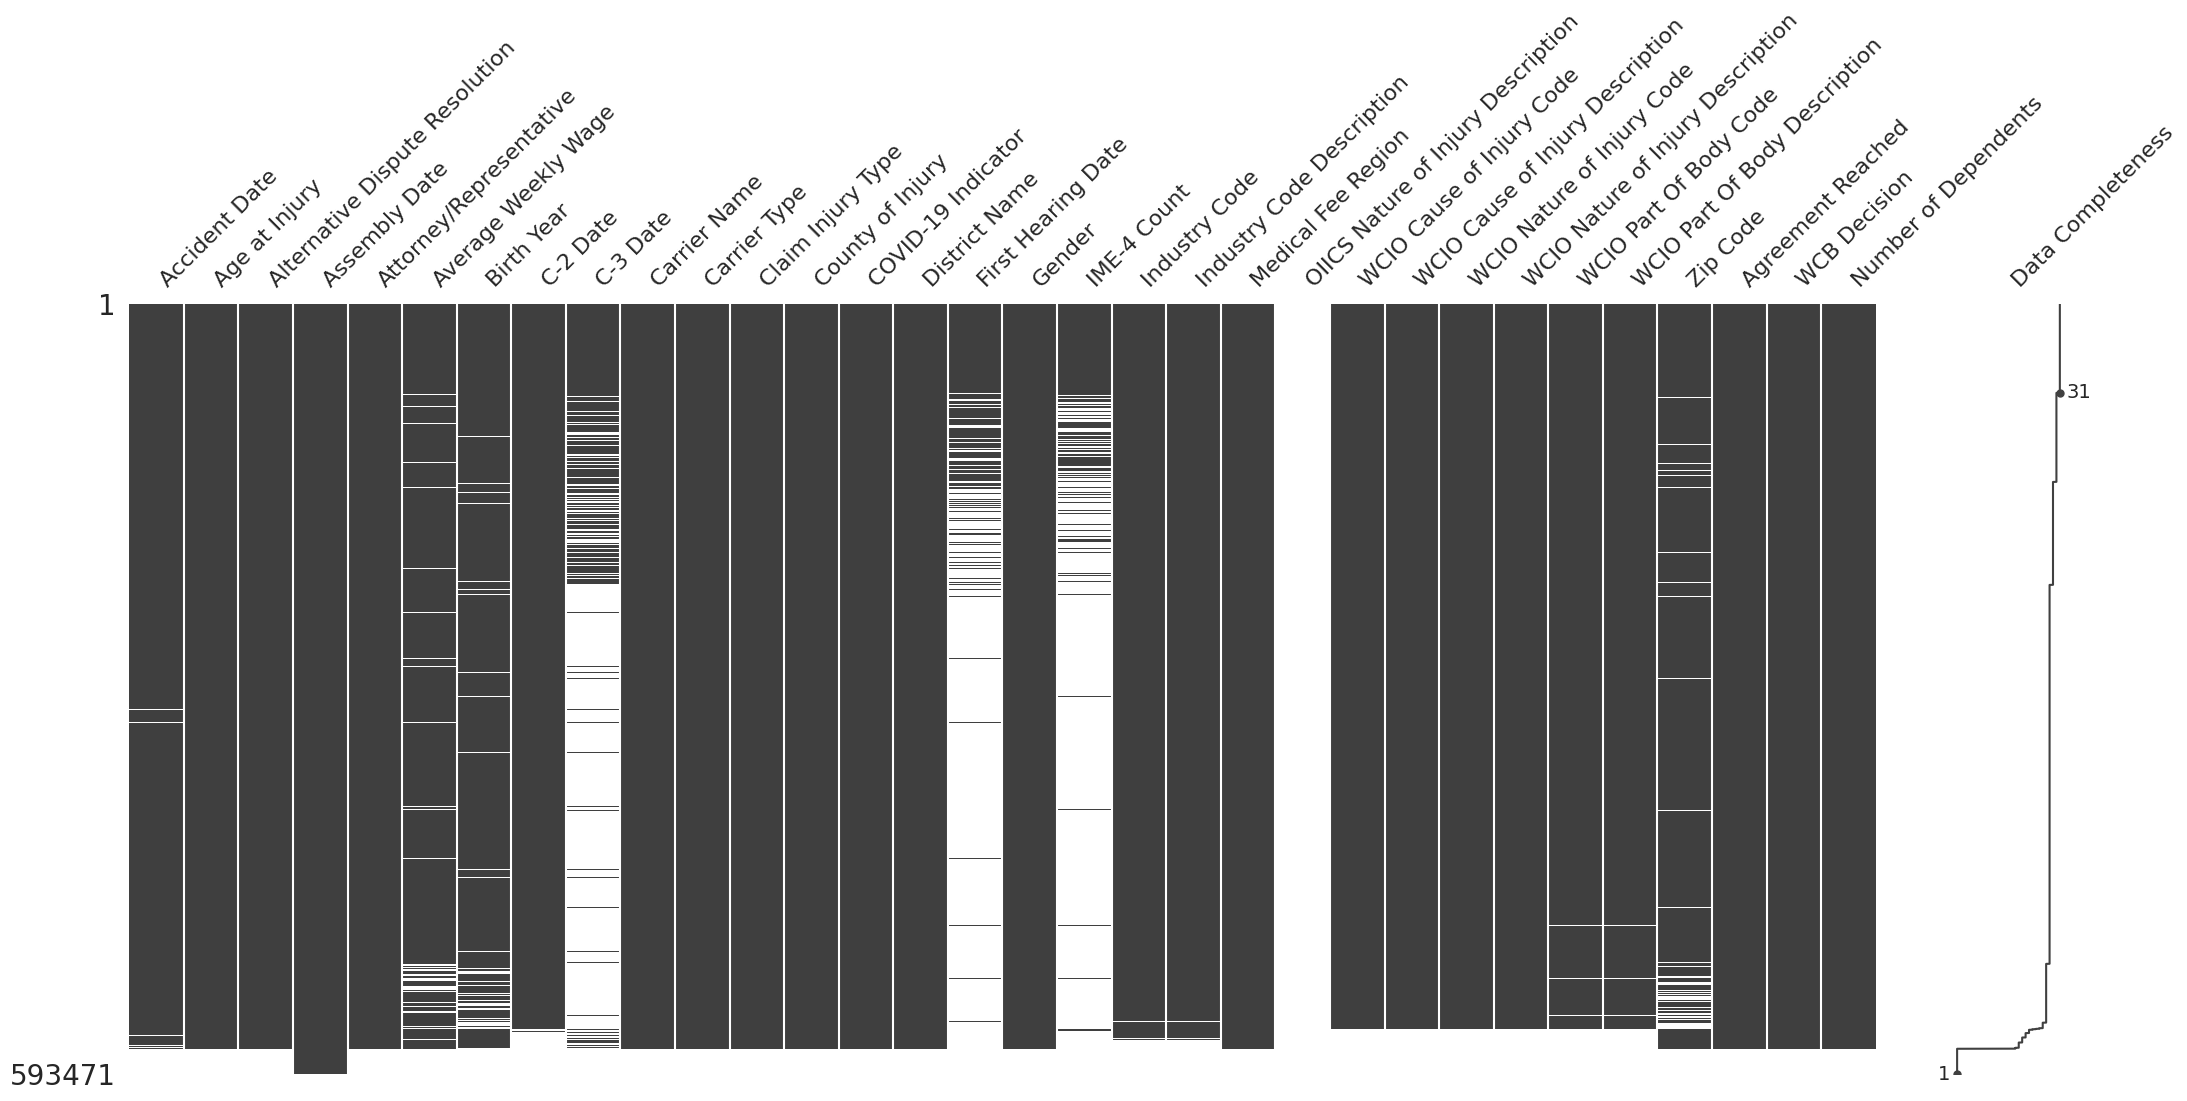

In [37]:

msno.matrix(data_train, labels=True, sort="descending");

- first hearing date - blank values mean it hasnt been set yet

In [38]:
## missing values
strange_values_list = ["!","$","%","?","*","+","_","@","€"," ","{"]
data_train.replace(strange_values_list,np.nan, inplace=True)

In [39]:
data_train.isna().sum()

,0
Accident Date,23134
Age at Injury,19445
Alternative Dispute Resolution,19445
Assembly Date,0
Attorney/Representative,19445
Average Weekly Wage,48096
Birth Year,48523
C-2 Date,34005
C-3 Date,406226
Carrier Name,19445


In [48]:
# check missing values percentage
missing_values_overview = data_train.isnull().mean() * 100
missing_values_sorted = missing_values_overview.sort_values()


print(missing_values_sorted)



Assembly Date                         0.000000
Number of Dependents                  3.276487
Age at Injury                         3.276487
Alternative Dispute Resolution        3.276487
Attorney/Representative               3.276487
Agreement Reached                     3.276487
Medical Fee Region                    3.276487
Gender                                3.276487
WCB Decision                          3.276487
Carrier Name                          3.276487
Carrier Type                          3.276487
Claim Injury Type                     3.276487
County of Injury                      3.276487
COVID-19 Indicator                    3.276487
District Name                         3.276487
Accident Date                         3.898084
Industry Code                         4.954412
Industry Code Description             4.954412
C-2 Date                              5.729850
WCIO Cause of Injury Code             5.911831
WCIO Cause of Injury Description      5.911831
WCIO Nature o

In [41]:
data_train.drop('OIICS Nature of Injury Description', inplace = True, axis = 1)

- Before to drop more columns we will do the correlation test

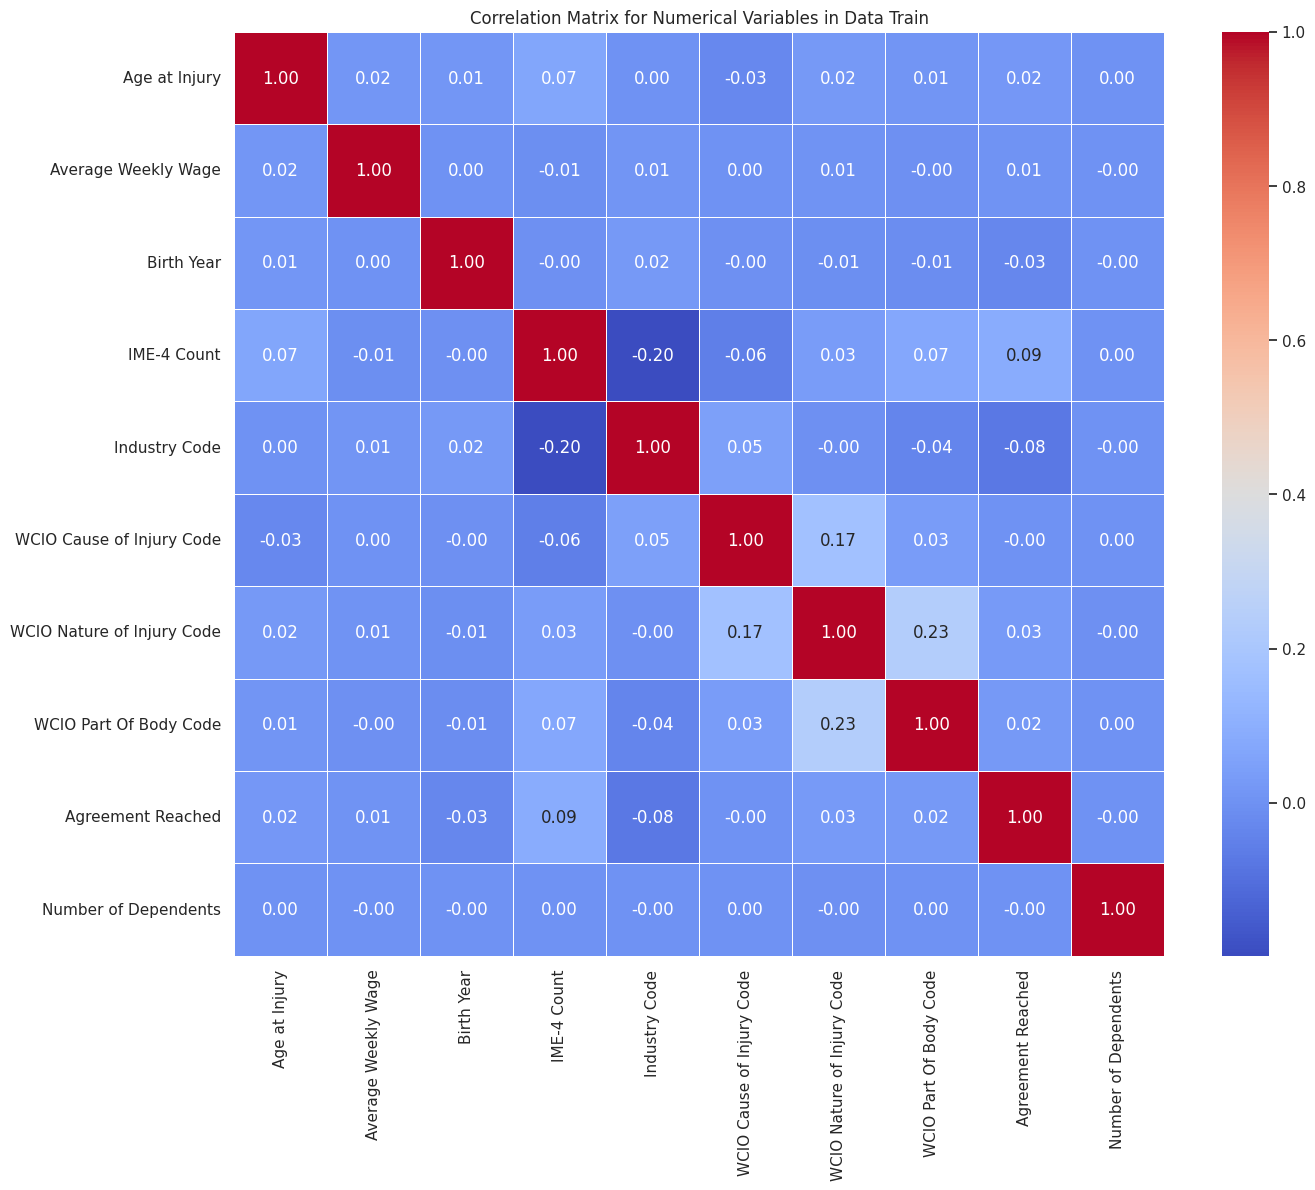

In [46]:
# Creating a correlation matrix for numerical variables only

# Select only numerical columns from 'data_train'
numerical_data = data_train.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix_numerical = numerical_data.corr()

# Plotting the correlation matrix with values in each cell
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix_numerical, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Numerical Variables in Data Train")
plt.show()



- The decision to discard the variables C-3 Date, First Hearing Date, and IME-4 Count is based on the following considerations:

- High Percentage of Missing Values: These columns have a high proportion of missing values — C-3 Date with 68.4%, First Hearing Date with 74.6%, and IME-4 Count with 77.6%. Imputing such a large amount of missing data could introduce biases and reduce the accuracy of the model.

- Low Correlation with Other Variables: Correlation analysis shows that these variables have little to no significant correlation with other numerical features. This indicates that they likely do not contribute meaningfully to the predictive power of the model.

- Data Simplification: Removing these columns helps simplify the dataset, making it easier to manage and potentially improving model performance by reducing noise.

- Given these reasons, these variables are unlikely to add substantial value to the analysis and can be safely removed.

In [49]:
# Remove columns with high missing values and low correlation
data_train = data_train.drop(columns=['C-3 Date', 'First Hearing Date', 'IME-4 Count'])


In [50]:
# check missing values percentage
missing_values_overview = data_train.isnull().mean() * 100
missing_values_sorted = missing_values_overview.sort_values()


print(missing_values_sorted)

Assembly Date                        0.000000
District Name                        3.276487
Agreement Reached                    3.276487
Medical Fee Region                   3.276487
Gender                               3.276487
WCB Decision                         3.276487
COVID-19 Indicator                   3.276487
County of Injury                     3.276487
Claim Injury Type                    3.276487
Number of Dependents                 3.276487
Carrier Name                         3.276487
Age at Injury                        3.276487
Carrier Type                         3.276487
Alternative Dispute Resolution       3.276487
Attorney/Representative              3.276487
Accident Date                        3.898084
Industry Code Description            4.954412
Industry Code                        4.954412
C-2 Date                             5.729850
WCIO Cause of Injury Description     5.911831
WCIO Cause of Injury Code            5.911831
WCIO Nature of Injury Code        

- **Try to solve the missing values with median mean and KNN**

In [52]:
# Fill missing values in numeric columns with the median
# Median is less influenced by extreme outliers
for col in data_train.columns:
    if pd.api.types.is_numeric_dtype(data_train[col]):
        median_to_fill = data_train[col].median()
        data_train[col].fillna(median_to_fill, inplace=True)


In [53]:
# Fill missing values in numeric columns with the mean
# (only if you prefer mean over median in specific columns)
## for col in train.columns:
##    if pd.api.types.is_numeric_dtype(train[col]):
##        mean_to_fill = train[col].mean()
##        train[col].fillna(mean_to_fill, inplace=True)


#**Perform data scaling**

Justification for Scaling Choices
The scaling and transformation methods were selected based on the nature of each variable:

Standard Scaling for Numerical Variables: Standard scaling was applied to numerical variables (such as Age at Injury, Average Weekly Wage, Birth Year, etc.) to normalize the differences in ranges and units across variables. This is particularly important for algorithms like regression, SVM, and neural networks, which are sensitive to varying scales.

One-Hot Encoding and Label Encoding for Categorical Variables: Categorical variables were converted to numerical representations. One-hot encoding was applied to multi-class categorical variables (e.g., Carrier Type, District Name), while label encoding was used for binary variables (e.g., Agreement Reached, COVID-19 Indicator). This approach ensures that categorical data can be processed by machine learning algorithms that require numerical input.

Date Conversion: Date columns (such as Accident Date, Assembly Date, etc.) were converted to ordinal values (days since a reference date) to enable their use as numerical features if needed. This allows date-based variables to be represented in a consistent numeric format.

These scaling and transformation choices ensure that all variables are on a compatible scale and in a usable format for modeling, enhancing model performance and interpretability.

In [55]:
from sklearn.preprocessing import StandardScaler

# Selecionar colunas numéricas para escalonamento
numerical_cols = [
    'Age at Injury', 'Average Weekly Wage', 'Birth Year',
    'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
    'WCIO Part Of Body Code'
]

# Inicializar o escalador e ajustar aos dados
scaler = StandardScaler()
data_train[numerical_cols] = scaler.fit_transform(data_train[numerical_cols])


In [59]:
# Converter colunas de data para ordinal (dias desde uma data de referência)
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date']
for col in date_columns:
    data_train[col] = pd.to_datetime(data_train[col], errors='coerce').map(lambda x: x.toordinal() if pd.notnull(x) else pd.NA)


In [63]:
# One-hot encoding para variáveis categóricas multiclasses
categorical_cols_multiclass = ['Carrier Type', 'District Name', 'WCB Decision']
data_train = pd.get_dummies(data_train, columns=categorical_cols_multiclass, drop_first=True)

# Label encoding para variáveis binárias
binary_cols = ['Agreement Reached', 'COVID-19 Indicator', 'Alternative Dispute Resolution', 'Attorney/Representative', 'Gender']
for col in binary_cols:
    data_train[col] = data_train[col].map({'Yes': 1, 'No': 0})  # ajuste conforme o seu dataset


## **Accident Date**

## **Age at Injury**

## **Alternative Dispute Resolution**

## **Assembly Date**

## **Attorney/Representative**

## **Average Weekly Wage**

## **Birth Year**

## **C-2 Date**

## **C-3 Date**

## **Carrier Name**

## **Carrier Type**

## **Claim Identifier**##

## **County of Injury**##

## **COVID-19 Indicator**##

## **District Name**##

## **First Hearing Date**


## **Gender**

## **IME-4 Count**##

## **Industry Code**##

## **Industry Code Description**##

## **Medical Fee Region**##

## **OIICS Nature of Injury Description**##

## **WCIO Cause of Injury Code**##

## **WCIO Cause of Injury Description**##

## **WCIO Nature of Injury Code**##

## **WCIO Nature of Injury Description**##

## **WCIO Part Of Body Description**##

## **Zip Code**##

## **Agreement Reached**##

## **WCB Decision**##

## **Claim Injury Type**##

In [43]:
data['Claim Injury Type'].value_counts()

,count
Claim Injury Type,
2. NON-COMP,291078
4. TEMPORARY,148507
3. MED ONLY,68906
5. PPD SCH LOSS,48280
1. CANCELLED,12477
6. PPD NSL,4211
8. DEATH,470
7. PTD,97


In [44]:
data = data.dropna(subset=['Claim Injury Type']).reset_index(drop=True)
data['Claim Injury Type'] = data['Claim Injury Type'].astype(str)
data['Claim Injury Type Num'] = data['Claim Injury Type'].str.extract('^(\d+)').astype(int)
data = data.drop(columns=['Claim Injury Type'])

# **APPENDIX - Numerical Columns**